# ES-RNN model 

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement an Exponential Smoothing RNN (ES-RNN)<sup>1,2</sup> model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses recent values of load as the model input. The model will be trained to output a vector, the elements of which are ordered predictions for future time steps.
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>3</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Slawek Smyl, Jai Ranganathan, and Andrea Pasqua. "M4 Forecasting Competition: Introducing a New Hybrid ES-RNN Model", 2018. URL https://eng.uber.com/m4-forecasting-competition/.<br>
<sup>2</sup>Andrew Redd and Kaung Khin and Aldo Marini, "Fast ES-RNN: A GPU Implementation of the ES-RNN Algorithm", Jul 2019, URL https://arxiv.org/abs/1907.03329. <br>
<sup>3</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
import os
import datetime as dt
from collections import UserDict, deque
from common.utils import TimeSeriesTensor, create_evaluation_df

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Load the data from csv into a Pandas dataframe. Make sure to first complete the [0_data_setup](0_data_setup.ipynb) notebook.

In [2]:
file_name = os.path.join('data', 'energy.parquet')
energy = pd.read_parquet(file_name)
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


## Data preparation

For this example, we will set *T=6*. This means that the input for each sample is a vector of the prevous 6 hours of the energy load. The choice of *T=6* was arbitrary but should be selected through experimentation.

*HORIZON=3* specifies that we have a forecasting horizon of 3 (*t+3*)

In [3]:
# Note: the dates below are chosen to ensure that the number of samples in each of the splits are integer multiples
# of the training batch size (48). This is a limitation of the ES-RNN implementation below.

valid_start_dt = '2014-08-30 13:00:00'
test_start_dt = '2014-10-31 15:00:00'
test_end_dt = '2014-12-31 04:00:00'

T = 12
HORIZON = 3

Create training set.

In [4]:
train = energy.copy()[:valid_start_dt][['load']]

Scale data. This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train[['load']])
train[['load']] = scaler.transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [6]:
tensor_structure = {'X':(range(-T+1, 1), ['load'])}
train_inputs = TimeSeriesTensor(train, 'load', HORIZON, tensor_structure)

In [7]:
train_inputs.dataframe.head(3)

tensor              target                 X                                \
feature                  y              load                                 
time step              t+1   t+2   t+3  t-11  t-10   t-9   t-8   t-7   t-6   
2012-01-01 11:00:00  -0.22 -0.28 -0.33 -1.07 -1.32 -1.52 -1.59 -1.59 -1.50   
2012-01-01 12:00:00  -0.28 -0.33 -0.30 -1.32 -1.52 -1.59 -1.59 -1.50 -1.31   
2012-01-01 13:00:00  -0.33 -0.30  0.31 -1.52 -1.59 -1.59 -1.50 -1.31 -1.03   

tensor                                                   
feature                                                  
time step             t-5   t-4   t-3   t-2   t-1     t  
2012-01-01 11:00:00 -1.31 -1.03 -0.69 -0.36 -0.24 -0.23  
2012-01-01 12:00:00 -1.03 -0.69 -0.36 -0.24 -0.23 -0.22  
2012-01-01 13:00:00 -0.69 -0.36 -0.24 -0.23 -0.22 -0.28

In [8]:
print("y_train shape: ", train_inputs['target'].shape)
print("x_train shape: ", train_inputs['X'].shape)

y_train shape:  (23328, 3)
x_train shape:  (23328, 12, 1)


Construct validation set (keeping T hours from the training set in order to construct initial features)

In [9]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[look_back_dt:test_start_dt][['load']]
valid[['load']] = scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, 'load', HORIZON, tensor_structure)

print("y_valid shape: ", valid_inputs['target'].shape)
print("x_valid shape: ", valid_inputs['X'].shape)

y_valid shape:  (1488, 3)
x_valid shape:  (1488, 12, 1)


## Implement ES-RNN

We will implement ES-RNN forecasting model with the following structure:

![ES-RNN](./images/es_rnn.png)

In [10]:
LATENT_DIM = 5 # number of units in the RNN layer
BATCH_SIZE = 48 # number of samples per mini-batch
EPOCHS = 20 # maximum number of times the training algorithm will cycle through all samples
m = 24 # seasonality length

Check that train and validation set lenghts are multiple of BATCH_SIZE

In [11]:
n = train_inputs['X'].shape[0]
assert n % BATCH_SIZE == 0, f'Train set size, {n:,} is not a multiple of batch size ({BATCH_SIZE})'
n = valid_inputs['X'].shape[0]
assert n % BATCH_SIZE == 0, f'Validation set size, {n:,} is not a multiple of batch size ({BATCH_SIZE})'

### Create custom layers in Keras
In this section we define two custom layers:
- ***ES*** layer: This layer implements the Expomemtial Smoothing,  normalization and de-seasonalization for input data.
- ***Denormalization*** layer: This layer takes the normalization and de-seasonalization coefficients from ES layer and multiply them to output of RNN for de-normalization and seasonalization.


There are 3 methods you need to implement in your custom layer:
- `build(input_shape)`: this is where you will define your weights.
- `call(x)`: this is where the layer's logic lives.
- `compute_output_shape(input_shape)`: in case your layer modifies the shape of its input, you should specify here the shape transformation logic. 

You can check [Keras documentation](https://keras.io/layers/writing-your-own-keras-layers/) for more details about creating custom layer.

In [12]:
from keras import backend as K
from keras.layers import Layer
from keras import initializers

# Exponential Smoothing + Normalization
class ES(Layer):

    def __init__(self, horizon, m, batch_size, time_steps, **kwargs):
        self.horizon = horizon
        self.m = m
        self.batch_size = batch_size
        self.time_steps = time_steps
        
        super(ES, self).__init__(**kwargs)

    # initialization of the trainable parameters of exponential smoothing
    def build(self, input_shape):
        self.alpha = self.add_weight(name='alpha', shape=(1,),
                                     initializer='uniform', trainable=True)
        self.gamma = self.add_weight(name='gamma', shape=(1,),
                                     initializer='uniform', trainable=True)
        self.init_seasonality = self.add_weight(name='init_seasonality', shape=(self.m,),
                                                initializer=initializers.Constant(value=0.8), trainable=True)
        self.init_seasonality_list = [K.slice(self.init_seasonality,(i,),(1,)) for i in range(self.m)]
        self.seasonality_queue = deque(self.init_seasonality_list, self.m)
        self.level = self.add_weight(name='init_level', shape=(1,),
                                     initializer=initializers.Constant(value=0.8), 
                                     trainable=True)
        super(ES, self).build(input_shape)  

    def call(self, x):

        # extract time-series from feature vector
        n_examples = K.int_shape(x)[0]
        if n_examples is None:
            n_examples = self.batch_size
        x1 = K.slice(x,(0,0,0),(1,self.time_steps,1))
        x1 = K.reshape(x1,(self.time_steps,))
        x2 = K.slice(x,(1,self.time_steps-1,0),(n_examples-1,1,1))
        x2 = K.reshape(x2,(n_examples-1,))
        ts = K.concatenate([x1,x2])
        
        x_norm = []  # normalized values of time-series
        ls = []      # coeffients for denormalization of forecasts
        
        l_t_minus_1 = self.level
        
        for i in range(n_examples+self.time_steps-1):
        
            # compute l_t
            y_t = ts[i]
            s_t = self.seasonality_queue.popleft()
            l_t = self.alpha * y_t / s_t + (1 - self.alpha) * l_t_minus_1
            
            # compute s_{t+m}
            s_t_plus_m = self.gamma * y_t / l_t + (1 - self.gamma) * s_t
            
            self.seasonality_queue.append(s_t_plus_m)
            
            # normalize y_t
            x_norm.append(y_t / (s_t * l_t))

            l_t_minus_1 = l_t

            if i >= self.time_steps-1:
                l = [l_t]*self.horizon
                l = K.concatenate(l)
                s = [self.seasonality_queue[i] for i in range(self.horizon)] # we assume here that horizon < m
                s = K.concatenate(s)
                ls_t = K.concatenate([K.expand_dims(l), K.expand_dims(s)])
                ls.append(K.expand_dims(ls_t,axis=0))  
       
        self.level = l_t
        x_norm = K.concatenate(x_norm)

        # create x_out
        x_out = []
        for i in range(n_examples):
            norm_features = K.slice(x_norm,(i,),(self.time_steps,))
            norm_features = K.expand_dims(norm_features,axis=0)
            x_out.append(norm_features)

        x_out = K.concatenate(x_out, axis=0)
        x_out = K.expand_dims(x_out)

        # create tensor of denormalization coefficients 
        denorm_coeff = K.concatenate(ls, axis=0)
        return [x_out, denorm_coeff]

    def compute_output_shape(self, input_shape):
        return [(input_shape[0], input_shape[1], input_shape[2]), (input_shape[0], self.horizon, 2)]
    
class Denormalization(Layer):
    
    def __init__(self, **kwargs):
        super(Denormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Denormalization, self).build(input_shape)  

    def call(self, x):
        return x[0] * x[1][:,:,0] * x[1][:,:,1]

    def compute_output_shape(self, input_shape):
        return input_shape[0]

Using TensorFlow backend.


### Create ES-RNN model
Since Denormalization layer has inputs from two previous layers, we need to use functional API of Keras to create the model.

In [13]:
from keras.models import Model
from keras.layers import Input, GRU, Dense, Lambda
from keras.callbacks import EarlyStopping

model_input = Input(shape=(None, 1))
[normalized_input, denormalization_coeff] = ES(HORIZON, m, BATCH_SIZE, T)(model_input)
gru_out = GRU(LATENT_DIM)(normalized_input)
model_output_normalized = Dense(HORIZON)(gru_out)
model_output = Denormalization()([model_output_normalized, denormalization_coeff])
model = Model(inputs=model_input, outputs=model_output)

model.compile(optimizer='RMSprop', loss='mse')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
es_1 (ES)                       [(None, None, 1), (N 27          input_1[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 5)            105         es_1[0][0]                       
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3)            18          gru_1[0][0]                      
____________________________________________________________________________________________

In [14]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [15]:
%%time
history = model.fit(
    train_inputs['X'],
    train_inputs['target'],
    batch_size=BATCH_SIZE,
    shuffle=False,
    epochs=EPOCHS,
    validation_data=(valid_inputs['X'], valid_inputs['target']),
    callbacks=[earlystop],
    verbose=1)

Train on 23328 samples, validate on 1488 samples
Epoch 1/20
23328/23328 [==============================] - 7s 304us/step - loss: 2.9203 - val_loss: 0.4404
Epoch 2/20
23328/23328 [==============================] - 4s 159us/step - loss: 0.4082 - val_loss: 0.2719
Epoch 3/20
23328/23328 [==============================] - 3s 146us/step - loss: 0.2218 - val_loss: 0.2027
Epoch 4/20
23328/23328 [==============================] - 3s 150us/step - loss: 0.1623 - val_loss: 0.1763
Epoch 5/20
23328/23328 [==============================] - 3s 145us/step - loss: 0.1314 - val_loss: 0.1832
Epoch 6/20
23328/23328 [==============================] - 3s 146us/step - loss: 0.1041 - val_loss: 0.1847
Epoch 7/20
23328/23328 [==============================] - 3s 147us/step - loss: 0.0920 - val_loss: 0.1706
Epoch 8/20
23328/23328 [==============================] - 3s 149us/step - loss: 0.0832 - val_loss: 0.1707
Epoch 9/20
23328/23328 [==============================] - 4s 151us/step - loss: 0.0798 - val_loss: 0.17

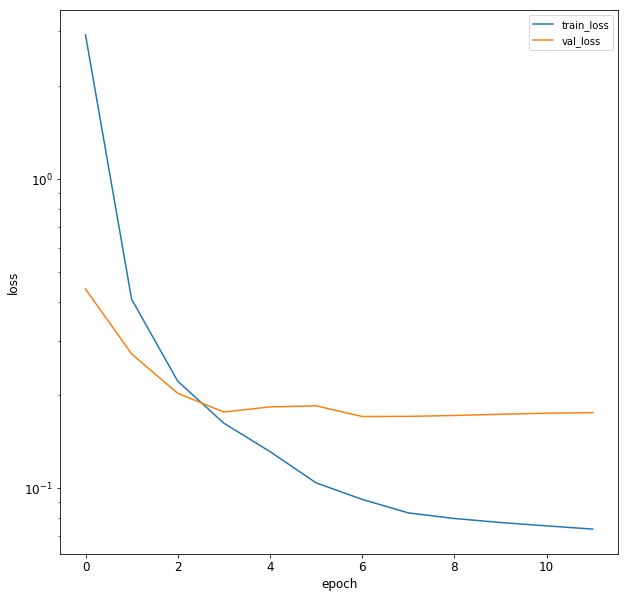

In [16]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

## Evaluate the model

In [17]:
test = energy.copy()[test_start_dt:test_end_dt][['load']]
test[['load']] = scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'load', HORIZON, tensor_structure)

Check that the test set lenght is a multiple of BATCH_SIZE

In [18]:
n = test_inputs['X'].shape[0]
assert n % BATCH_SIZE == 0, f'Test set size, {n:,} is not a multiple of batch size ({BATCH_SIZE})'

In [19]:
predictions = model.predict(test_inputs['X'], batch_size=BATCH_SIZE)

In [20]:
predictions

array([[-1.57, -1.49, -1.19],
       [-1.59, -1.34, -0.98],
       [-1.31, -0.92, -0.49],
       ...,
       [-0.28, -0.47, -0.65],
       [-0.53, -0.67, -0.78],
       [-0.6 , -0.58, -0.58]], dtype=float32)

Combine predictions with actual values, then unpivot for easier analysis. 

In [21]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, scaler)
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 02:00:00,t+1,"2,411.74","2,382.00"
1,2014-11-01 03:00:00,t+1,"2,400.63","2,419.00"
2,2014-11-01 04:00:00,t+1,"2,560.75","2,520.00"
3,2014-11-01 05:00:00,t+1,"2,685.31","2,714.00"
4,2014-11-01 06:00:00,t+1,"2,967.65","2,970.00"


Compute MAPE for each forecast horizon

In [22]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   0.02
t+2   0.05
t+3   0.07
Name: APE, dtype: float64

Compute MAPE across all predictions

In [23]:
from common.utils import mape

print("MAPE: {:.2f}%".format(100* mape(eval_df['prediction'], eval_df['actual'])))

MAPE: 4.75%


Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

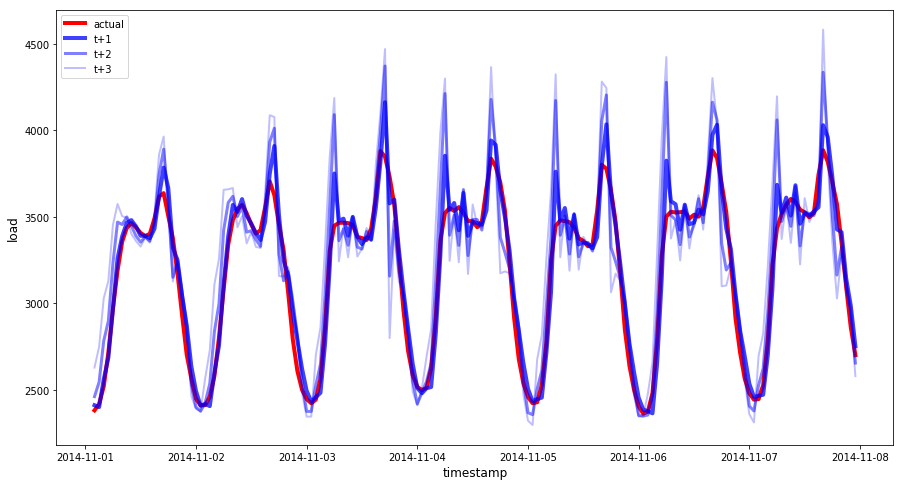

In [24]:
plot_df = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()